In [1]:
import numpy as np 
import pandas as pd
from scipy.special import softmax 
import time 

from copy import deepcopy

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 

import sys 
sys.path.append("..") 
from utils.viz import viz 
viz.get_style()

In [2]:
class two_stage_task:
    '''The two stage task

    The task reported in Daw et al., 2011 is a
    two-stage MDP. The task is written in the gym
    format. Here we will define the 4-tuple
    for this MDP (S, A, T, R)

    S: the state space, 
    A: the action space, 
    P: the transition fucntion, 
    R: the reward function,
    '''
    nS = 3 
    nA = 2

    def __init__(self, type=0, rho=.9, seed=2023):
        self.type  = type
        self.rho   = rho  # transition probability
        self.rng   = np.random.RandomState(seed)
        # define MDP 
        self._init_S()
        self._init_A()
        self._init_P()
        self._init_R()

    # -------- Define the task -------- #
        
    def _init_S(self):
        self.S = [0, 1, 2]

    def _init_A(self):
        self.A = [0, 1]

    def _init_P(self):
        '''The transition function

        The transition matrix is:

                 s0     s1      s2      
        s0-a0    0      t       1-t   t = rho aka 0.7
        s0-a1    0      1-t     t  

        s1-a0    1      0       0        
        s1-a1    1      0       0   
    
        s2-a0    1      0       0      
        s2-a1    1      0       0    
        '''
        self.P = np.zeros([self.nS, self.nA, self.nS])
        # state == 0 
        self.P[0, 0, :] = [0, self.rho, 1-self.rho]
        self.P[0, 1, :] = [0, 1-self.rho, self.rho]
        # state != 0 
        self.P[1:, :, 0] = 1
        # common state 
        self.common_state = 1 if self.rho > .5 else 2
        def p_s_next(s, a):
            return self.P[s, a, :].copy()
        self.p_s_next = p_s_next

    def _init_R(self):
        '''The reward function

            the probability of getting reward

                    p(r|s, a)      
            s0-a0      0              
            s0-a1      0             

            s1-a0     .9               
            s1-a1     .4             

            s2-a0     .1           
            s2-a1     .6        
        '''
        def r_fn(s, a):
            r_mat = np.zeros([3, 2])
            if self.type==0:
                r_mat[1, 0] = .9
                r_mat[1, 1] = .4
                r_mat[2, 0] = .1 
                r_mat[2, 1] = .6
            elif self.type==1:
                r_mat[1, 0] = .6
                r_mat[1, 1] = .1
                r_mat[2, 0] = .4 
                r_mat[2, 1] = .9
            elif self.type==2:
                r_mat[1, 0] = .1
                r_mat[1, 1] = .6
                r_mat[2, 0] = .9 
                r_mat[2, 1] = .4
            elif self.type==3:
                r_mat[1, 0] = .4
                r_mat[1, 1] = .9
                r_mat[2, 0] = .6 
                r_mat[2, 1] = .1
            p = np.clip(r_mat[s, a] + 0.025*self.rng.randn(), .25, .75)
            return self.rng.choice([0, 1], p=[1-p, p])
        self.r_fn = r_fn
    
    # -------- Run the task -------- #

    def reset(self):
        '''Reset the task, always start with state=0
        '''
        self.s = 0
        self.t = -1
        self.r = 0 
        self.done = False
        info = {'stage': 0}
        return self.s, self.r, self.done, info
      
    def step(self, a):
        '''For each trial 

        Args:
            a: take the action conducted by the agent 

        Outputs:
            s_next: the next state
            rew: reward 
            info: some info for analysis 
        '''
        if a is None: a=0
        # Rt(St, At)
        self.r = self.r_fn(int(self.s), int(a))
        # St, At --> St+1 
        s_next = self.rng.choice(self.nS, p=self.p_s_next(self.s, a))
        # if the state is common 
        if s_next != 0: self.t += 1
        # if it is the end of the trial
        self.done = 1 if s_next == 0 else 0
        # info
        info = {
            'stage': 1 if s_next==0 else 0,
            'common': 'common' if int(a)+1==s_next else 'rare',
            'rewarded': 'rewarded' if self.r else 'unrewarded',
        }
        # if self.s==0: 
        #     print(a, s_next)
        #     print(int(a)+1==s_next)
        # now at the next state St
        self.s = s_next 
        return s_next, self.r, self.done, deepcopy(info)

In [3]:
env = two_stage_task()

In [4]:
def sim(agent_fn, params, n_episode = 5000, seed=1422):
    cols = ['a1', 's2', 'a2', 'r2', 'w', 'block_type']
    sim_data = {col: [] for col in cols}
    nS, nA = 3, 2
    rng = np.random.RandomState(seed)
    for typ in [0]:
        agent = agent_fn(nS, nA, rng, params=params)
        env = two_stage_task(type=typ,seed=seed*2)
        for epi in range(n_episode):
            # stage 1
            s1, _, _, _ = env.reset()          # get state 
            a1 = agent.make_move(s1)           # get action
            # stage 2
            s2, r1, done, info = env.step(a1)  # get state 
            a2 = agent.make_move(s2)           # get action 
            s3, r2, done, _ =env.step(a2)      # get reward
            agent.learn(s1, a1, s2, a2, r2)   
            # save
            sim_data['a1'].append(a1)
            sim_data['s2'].append(s2)
            sim_data['a2'].append(a2)
            sim_data['r2'].append(r2)
            sim_data['w'].append(agent.w.copy()) 
            sim_data['block_type'].append(info['common'])

    sim_data = pd.DataFrame.from_dict(sim_data) 
    sim_data['if_rewarded'] = sim_data['r2'].map(
        {0: 'unrewarded', 1: 'rewarded'}
    )   
    sim_data['a1_next'] = sim_data['a1'].shift(-1)
    sim_data['if_stay'] = sim_data.apply(
        lambda x: x['a1'] == x['a1_next']
    , axis=1)
    return sim_data 

## The behavior of arbitrator who minimizes loss

In [5]:
class lossarbi:
    '''SARSA + Model-based
    '''

    def __init__(self, nS, nA, rng, params):
        self.nS = nS
        self.nA = nA
        self.rng = rng
        self.Q_mf = np.zeros([nS, nA]) 
        self.Q_mb = np.zeros([nS, nA])  
        self.P    = np.array([[0, .9, .1],
                              [0, .1, .9]]) 
        self.alpha1 = params['alpha1']
        self.alpha2 = params['alpha2']
        self.beta1  = params['beta1']
        self.beta2  = params['beta2']
        self.lmbda  = params['lmbda']
        self.alpha_u = params['alpha_u']
        self.u      = 0
        self.w      = 0.5
        self.p      = params['p']
        self.eta    = params['eta']
        self.rep_a  = np.zeros([self.nA]) 

    def make_move(self, s):
        q_mf = self.Q_mf[s, :]
        q_mb = self.Q_mb[s, :]
        q_net = self.w*q_mb + (1-self.w)*q_mf
        beta = self.beta1 if s==0 else self.beta2
        q = q_net + self.p*self.rep_a
        pi = softmax(beta*q)
        return self.rng.choice(self.nA, p=pi) 
    
    def learn(self, s1, a1, s2, a2, r2):
        # model-free update 
        q_hat2 = self.Q_mf[s2, a2].copy()
        q_hat1 = self.Q_mf[s1, a1].copy()
        delta2 = r2 - q_hat2
        delta1 = q_hat2 - q_hat1
        self.Q_mf[s2, a2] += self.alpha2*delta2
        self.Q_mf[s1, a1] += self.alpha1*(delta1 + self.lmbda*delta2)

        # model-based update
        # level 2 is identical to model-free
        self.Q_mb[s2, a2] = self.Q_mf[s2, a2].copy()
        self.Q_mb[s1, :] = (self.P@np.max(self.Q_mb, axis=1, keepdims=True)).reshape([-1])
        
        # update perseveration
        self.rep_a = np.eye(self.nA)[a1]
       
        # update w
        # Loss = (wq_mb(s1,a1) + (1-w)q_mf(s1,a1) - (0 + eta * r2 ))^2
        grad_u = (self.w*self.Q_mb[s1,a1] + (1-self.w)*self.Q_mf[s1,a1] - self.eta*r2) * (self.Q_mb[s1,a1] - self.Q_mf[s1,a1]) * (1/(1+np.exp(-self.u))**2) * np.exp(-self.u)
        self.u = self.u - self.alpha_u*grad_u
        self.w = 1/(1+np.exp(-self.u))


# here we still assume that for the model-based learning, model is directly learned

In [6]:
agent_fn = lossarbi
params = {'alpha1': .4,
          'alpha2': .5, 
          'beta1': 6, 
          'beta2': 4, 
          'lmbda': .6,
          'alpha_u': .5,
          'p': .1,
          'eta':.99
          }
sim_LA_data = sim(agent_fn, params)

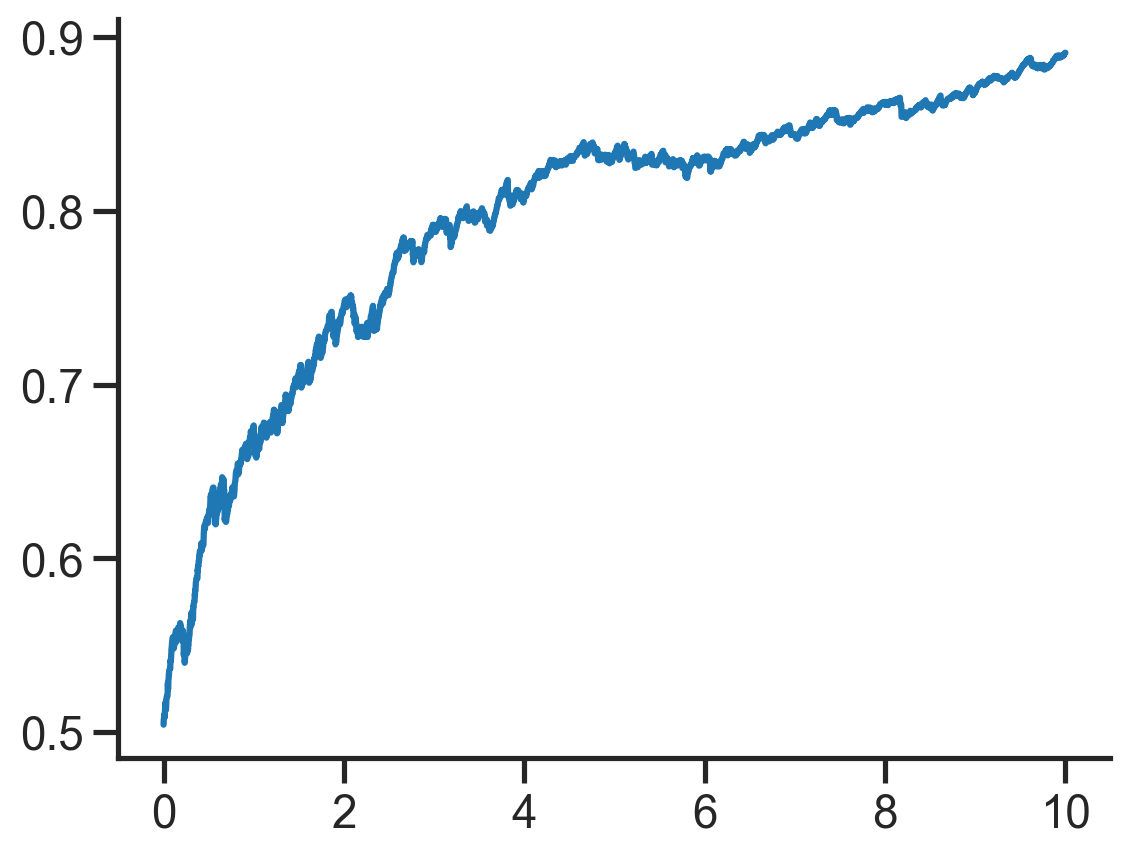

In [7]:
w = sim_LA_data['w']
x = np.linspace(0, 10, 5000)
plt.plot(x, w)